# Kaggle Challenge: Classifying Emotions of Tweets Using Only SVM and Random Forest

In this project, I created a model to perform sentiment analysis on tweets, working with a large labeled dataset of 400,000+ examples: https://www.kaggle.com/datasets/nelgiriyewithana/emotions.

I used only a combination of **Random Forest classifiers** and **Support Vector Machines (SVMs)** with a linear kernel (no deep learning allowed!) to get 93% testing accuracy.

This project demonstrates that even with an ambiguous task like emotion classification, it's possible to achieve accuracy that rivals deep learning approaches by doing careful data preprocessing and being thoughtful about leveraging and combining the strengths of traditional classifiers.


### `01_data_processing.ipynb`: data clean-up and processing, up until vectorization.

Data preprocessing is done in a **class-neural** manner, such that no emotion class inadvertently receives preferential treatment.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import re
from symspellpy import SymSpell, Verbosity

import nltk
import spacy

## Reading Emotions Dataset


In [ ]:
df = pd.read_csv('data/text.csv')

print(df.head())
print(len(df))

X = df['text']
Y = df['label']

   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4
416809


### Class distribution

First, I want to see how even the data sampling is, and if the representation of any emotions is unbalanced


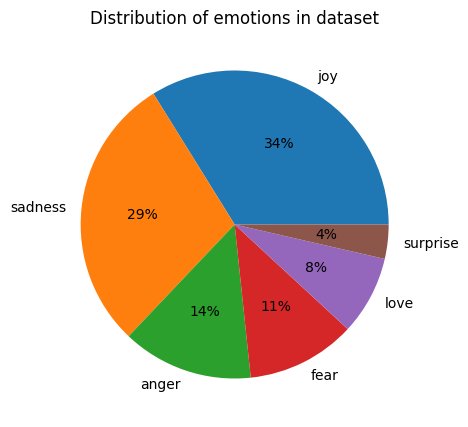

joy: 141067
sadness: 121187
anger: 57317
fear: 47712
love: 34554
surprise: 14972



In [3]:
label_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

label_counts = df['label'].map(label_mapping).value_counts()

plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.f%%')
plt.title('Distribution of emotions in dataset')
plt.show()

print("".join(f"{label}: {count}\n" for label, count in label_counts.items()))

It makes sense that joy & sadness are disproportionately represented as they're more common emotions. This will make things tricky with classifying emotions that are less represented but could use similar language to joy/sadness.


### Searching for leftover HTML

The data has already been cleaned of double spaces, special characters, punctuation, numbers, emojis, etc. However, since these are tweets, converting them to text may have left HTML tag words behind.


In [4]:
html_words = [
    " amp ", " lt ", " gt ", " quot ", " apos ", " nbsp ", " ndash ", " mdash ",
    " img ", " div ", " ref ", " src ", " url ", " alt ", " h ", " href ", 
    " br ", " p ", " ul ", " ol ", " li ", " em ", " b ", " f ",
    " http ", " www ", " com ", " span ", " iframe ", " textarea ",
    " html ", " head ", " title ", " meta ", " body ", " h1 ", " h2 ", " h3 ", " h4 ", " h5 ", " h6 ",
    " name ", " strong ", " mark ", " small ", " del ", " ins ", " sub ", " sup ", " table ",
    " th ", " tr ", " td ", " thead ", " tbody ", " tfoot ", " form ", " input ", " button ", " select ",
    " option ", " target ", " blank ", " download ", " itemtype ", " style ", " clearboth ", " padding ",
    " bottom ", " width ", " https ", " allowfullscreen ", " frameborder ", " sandbox ", " srcdoc ",
    " class ", " margin ", " marginheight ", " marginwidth ", " allowtransparency ", " poll ", " widget ",
    " draggable ", " tabindex ", " style ", " id ", " aria ", " label ", " static ", " px ", " font ",
    " sans ", " serif ", " block ", " overflow ", " inline ", " display ", " border "
]

html_word_counts = {word: 0 for word in html_words}

for text in X:
    for word in html_words:
        html_word_counts[word] += text.count(word)

for word, count in html_word_counts.items():
    print(f"{word}: {count}")

 amp : 2343
 lt : 153
 gt : 293
 quot : 9
 apos : 4
 nbsp : 19
 ndash : 0
 mdash : 0
 img : 676
 div : 56
 ref : 2
 src : 803
 url : 89
 alt : 83
 h : 99
 href : 4779
 br : 48
 p : 252
 ul : 2
 ol : 68
 li : 32
 em : 108
 b : 535
 f : 163
 http : 5219
 www : 3
 com : 26
 span : 181
 iframe : 44
 textarea : 2
 html : 18
 head : 2016
 title : 758
 meta : 28
 body : 2676
 h1 : 0
 h2 : 0
 h3 : 0
 h4 : 0
 h5 : 0
 h6 : 0
 name : 847
 strong : 2379
 mark : 238
 small : 1317
 del : 13
 ins : 17
 sub : 58
 sup : 2
 table : 329
 th : 575
 tr : 9
 td : 7
 thead : 0
 tbody : 0
 tfoot : 0
 form : 568
 input : 65
 button : 231
 select : 58
 option : 161
 target : 616
 blank : 1203
 download : 63
 itemtype : 7
 style : 1542
 clearboth : 31
 padding : 48
 bottom : 227
 width : 140
 https : 148
 allowfullscreen : 20
 frameborder : 25
 sandbox : 3
 srcdoc : 0
 class : 1922
 margin : 25
 marginheight : 3
 marginwidth : 3
 allowtransparency : 3
 poll : 12
 widget : 7
 draggable : 0
 tabindex : 0
 id : 246

It looks like URL and image embeddings are the biggest culprits, as well as &, <, >.

Remove: words that are obviously HTML

**DO NOT remove**: words that could be tied to emotion, as data processing must be class-neutral.


### Visual inspection

Displaying word clouds for each class label to see which words appear most often, understand the kind of comparisons the model will be making, and see what adjustments could be made before featurization.

Notes:

- These visuals exclude NLTK stopwords, since the plan is to remove them in the featurization process
- I also removed some additional custom words after noticing that they appear a lot for each emotion (i.e. "feel", "feeling") for visual inspection only, but these should **not** be removed for the actual featurization process as this could introduce class-based bias



Sadness:


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oanabinder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


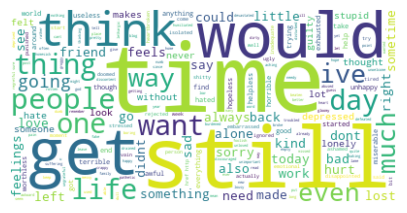

Joy:


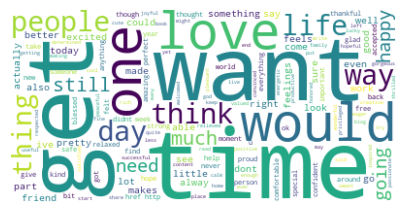

Love:


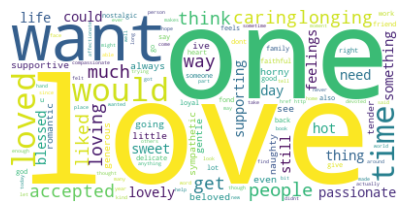

Anger:


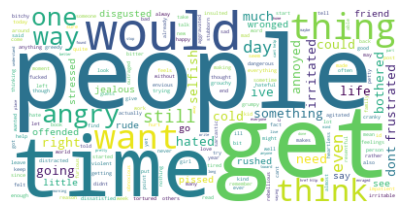

Fear:


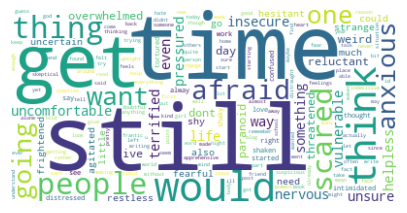

Surprise:


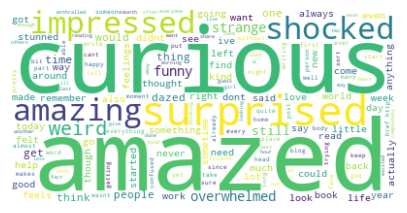

In [5]:

from nltk.corpus import stopwords
nltk.download('stopwords')

nltk_stopwords = set(stopwords.words('english'))

# remove these common words from visualization only, to better distinguish the difference between emotions
custom_stopwords = ["i", "im", "feel", "feeling", "like", "know", "make", "really"]

all_stopwords = set(custom_stopwords + list(nltk_stopwords))

def make_wordcloud(df, label):
    df_subset = df[df['label'] == label]
    text = " ".join(text for text in df_subset.text)

    wordcloud = WordCloud(stopwords=all_stopwords, background_color='white').generate(text)

    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

print("\nSadness:")
make_wordcloud(df, 0)

print("Joy:")
make_wordcloud(df, 1)

print("Love:")
make_wordcloud(df, 2)

print("Anger:")
make_wordcloud(df, 3)

print("Fear:")
make_wordcloud(df, 4)

print("Surprise:")
make_wordcloud(df, 5)

## Clean-up & Spell Check


Remove HTML words that were identified as significant and/or safe to remove without introducing bias:


In [6]:
html_to_remove = [
    " amp ", " lt ", " gt ", " nbsp ",
    " img ", " div ", " src ", " src", " alt ", " url ",
    " h ", " href ", " href", " br ", " p ", " ul ", " ol ", " li ", " em ", " f ", " b ",
    " http ", " http", " https ", " https", " www ", " www", " com ", " span ", " iframe ", " textarea ",
    " del ", " ins ", " sub ", " sup ", " html ", " target ", " blank ", " itemtype ",
    " clearboth ", " padding ", " width ", " allowfullscreen ", " frameborder ",
    " marginheight ", " marginwidth ", " allowtransparency ", " id ", " aria ", " label ",
    " static ", " px ", " font ", " sans ", " serif ", " inline ", " display ", " border "
]

regex_pattern = '|'.join([re.escape(word) for word in html_to_remove])

X = X.str.replace(regex_pattern, " ", regex=True).str.replace(r'\s{2,}', ' ', regex=True).str.strip()

Due to stripped punctuation, contractions appear broken (ex. don't -> don t). Deal with common contractions by converting them to words:


In [ ]:
contraction_map = {
    "wont": "will not",
    "won t": "will not",
    "cant": "cannot",
    "can t": "cannot",
    "dont": "do not",
    "don t": "do not",
    "isnt": "is not",
    "isn t": "is not",
    "didnt": "did not",
    "didn t": "did not",
    "doesnt": "does not",
    "doesn t": "does not",
    "im": "i am",
    "i m": "i am",
    "id": "i would",
    "i d": "i would",
    "ill": "i will",
    "i ll": "i will",
    "arent": "are not",
    "aren t": "are not",
    "wasnt": "was not",
    "wasn t": "was not",
    "werent": "were not",
    "weren t": "were not",
    "havent": "have not",
    "haven t": "have not",
    "hasnt": "has not",
    "hasn t": "has not",
    "hadnt": "had not",
    "hadn t": "had not",
    "couldnt": "could not",
    "couldn t": "could not",
    "shouldnt": "should not",
    "shouldn t": "should not",
    "mustnt": "must not",
    "mustn t": "must not",
    "wouldnt": "would not",
    "wouldn t": "would not",
    "lets": "let us",
    "let s": "let us",
    "youre": "you are",
    "you re": "you are",
    "theyre": "they are",
    "they re": "they are",
    "weve": "we have",
    "we ve": "we have",
    "ive": "i have",
    "i ve": "i have",
    "youve": "you have",
    "you ve": "you have",
    "theyve": "they have",
    "they ve": "they have",
    "theyd": "they would",
    "they d": "they would",
    "whos": "who is",
    "who s": "who is",
    "whats": "what is",
    "what s": "what is",
    "wheres": "where is",
    "where s": "where is",
    "whens": "when is",
    "when s": "when is",
    "hows": "how is",
    "how s": "how is",
    "heres": "here is",
    "here s": "here is",
    "theres": "there is",
    "there s": "there is",
    "shes": "she is",
    "she s": "she is",
    "hes": "he is",
    "he s": "he is",
    "isnt": "is not",
    "isn t": "is not",
    "yall": "you all",
    "y all": "you all",
    "aint": "is not",
    "ain t": "is not",
}

for contraction, expansion in contraction_map.items():
    regex_pattern = r'\b{}\b'.format(re.escape(contraction))
    X = X.str.replace(regex_pattern, expansion, regex=True)

Spell check using SymSpellPy to balance speed & accuracy, using a frequency dictionary of common English words: https://github.com/wolfgarbe/SymSpell/tree/master/SymSpell.FrequencyDictionary


In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary('dictionaries/en-80k.txt', term_index=0, count_index=1)

def spell_check(text):
    corrected_text = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        corrected_word = suggestions[0].term if suggestions else word
        corrected_text.append(corrected_word)
    
    return ' '.join(corrected_text)

# apply spell check & re-apply lowercasing since spell checker sometimes capitalizes
X = X.apply(spell_check)
X = X.str.lower()

X.head()

0         i just feel really helpless and heavy heated
1    i have enjoyed being able to slouch about rela...
2    i gave up my internship with the dark and am f...
3                         i do not know i feel so lost
4    i am a kindergarten teacher and i am thoroughl...
Name: text, dtype: object

Save cleaned text data for reference:


In [ ]:
if isinstance(X, pd.Series):
    X_cleaned = X.to_frame(name='processed_text')
else:
    X_cleaned = X

X_cleaned.to_csv('data/X_cleaned.csv', index=False)

## Lemmatization

- Remove common English **stop words** (articles, prepositions, conjuctions, etc.) that don't contribute to meaning
- Perform **Lemmatization**, to standardize the meanings of words by reducing them to their base form. This is an effective method for sentiment analysis as it removes noise while also preserving meaning more effectively than stemming, which can produce non-dictionary roots that might abstract away emotion cues.

Ultimately, capturing sublety between emotions is a main goal of sentiment analysis, so effective data processing should remove noise in the data to help the classifiers find boundaries more easily, while also maintaining diversity and nuance.


In [ ]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_and_stopwords_pipe(texts):
    results = []
    for doc in nlp.pipe(texts, batch_size=100, n_process=-1):
        results.append(' '.join([token.lemma_ for token in doc if not token.is_stop]))
    return results

X_processed = pd.Series(lemmatize_and_stopwords_pipe(X), index=X.index)

if isinstance(X_processed, pd.Series):
    X_processed_df = X_processed.to_frame(name='processed_text')
else:
    X_processed_df = X_processed

X_processed_df.to_csv('data/X_processed.csv', index=False)

Finishing touches: after skimming the processed data, it seems like some entries have a few lingering single letters, so remove those as they won't contribute to meaning after the previous clean-up steps. Also, double check to see if any tweets became completely blank after data processing.


In [ ]:
X_processed = pd.read_csv('data/X_processed.csv', dtype=str)['processed_text']
X_processed = pd.Series(X_processed.values)

def remove_single_letters(text):
    if isinstance(text, str):
        text = re.sub(r'\b\w\b', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(' ll ', ' ', text)
        return text.strip()

X_processed = X_processed.apply(remove_single_letters)

blank_indices = X_processed[X_processed.str.strip() == ''].index

print("Original tweets that are now blank:")
for i in blank_indices:
    print(f"index {i}: '{X.loc[i]}")

Original tweets that are now blank:


No blanks were created - save the final processed & lemmatized text data for reference.


In [ ]:
X_processed = X_processed.drop(blank_indices).reset_index(drop=True)
y = Y.drop(blank_indices).reset_index(drop=True)

df = pd.DataFrame({
    'text': X_processed,
    'label': y
})
df.to_csv('data/text_processed.csv', index=True, index_label='')